In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from scipy.stats import kendalltau
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import sys

script_dir = os.path.dirname(os.getcwd()) 
parent_dir = os.path.join(script_dir)
sys.path.append(parent_dir)  

from utils import compute_metrics

In [2]:
df = pd.read_csv('mnsol_summary.csv')
df

,EXP,OpenFF/TIP3P,ML/MM-ME,QM7-Species,Bespoke-Iter1-Species,Bespoke-Iter2-Species,Patched-Iter1-Species,Patched-Iter2-Species,Patched-Iter2-Refereence,Patched-Iter2-Species-LJ-Exp,Patched-Iter2-Species-LJ-MBIS
0,2.33,2.75,2.77,-1.17,1.34,1.33,1.13,1.21,1.32,2.24,1.19
1,2.89,3.05,2.87,-1.98,0.81,0.83,0.67,0.71,0.80,2.29,0.80
2,-0.87,-1.04,-1.07,0.57,-1.81,-1.96,-1.85,-1.84,-1.86,-1.05,-2.68
3,-2.39,-3.62,-3.60,-1.03,-3.69,-3.86,-3.50,-3.51,-3.78,-2.26,-4.07
4,-6.31,-6.40,-6.84,2.28,-9.98,-10.78,-8.47,-8.26,-7.78,-6.82,-7.58
5,-5.11,-3.93,-3.78,-3.17,-7.64,-7.69,-6.67,-6.48,-6.22,-5.18,-4.66
6,-5.87,-5.42,-6.56,-3.25,-8.41,-8.33,-7.93,-7.90,-8.09,-5.94,-6.18
7,-6.70,-6.97,-6.90,-8.31,-10.00,-9.71,-9.52,-9.32,-9.70,-7.01,-6.03
8,-5.05,-3.82,-3.78,-0.41,-5.04,-5.23,-6.08,-5.81,-5.75,-4.95,-5.06
9,-2.57,-3.11,-3.34,-4.44,-6.39,-6.22,-5.08,-4.58,-4.61,-2.46,-4.27


In [3]:
eps_07 = [
    1.74, 1.47, -1.19, -2.64, -6.90, -5.22, -6.42, -8.32, -4.83, -3.63, 
    -5.00, -3.31, -2.46, -10.48, -5.26, -3.80, -6.11, -10.32, -0.25, -1.83
]

eps_08 = [
    1.51, 1.20, -1.40, -2.89, -7.20, -5.62, -6.95, -8.62, -5.12, -3.94, 
    -5.33, -3.63, -2.83, -11.09, -5.52, -4.08, -6.11, -10.83, -0.52, -2.09
]

eps_09 = [
    1.39, 1.00, -1.61, -3.18, -7.69, -6.00, -7.43, -8.92, -5.46, -4.33, 
    -5.67, -3.97, -3.15, -11.56, -5.90, -4.44, -6.53, -11.54, -0.69, -2.38
]

lj_boltzmann = [
    0.46, -0.20, -1.83, -3.21, -10.55, -4.90, -6.60, -7.12, -7.17, -4.81, 
    -5.34, -4.32, -3.87, -9.43, -7.07, -5.36, -7.17, -10.86, -2.12, -2.64
]


df['Patched-Iter2-Species-LJ-DES370K']= lj_boltzmann 


In [4]:
# new dataset with OpenFF/TIP3P, QM7, Bespoke-Iter2-Species, Patched-Iter2-Species

# create new dataset
df_new = pd.DataFrame()
df_new['EXP'] = df['EXP']
df_new['OpenFF/TIP3P'] = df['OpenFF/TIP3P']
df_new['Original EMLE'] = df['QM7-Species']
df_new['Bespoke Model'] = df['Bespoke-Iter2-Species']
df_new['Patched Model'] = df['Patched-Iter2-Species-LJ-DES370K']
df = df_new

0    -0.42
1    -0.16
2     0.17
3     1.23
4     0.09
5    -1.18
6    -0.45
7     0.27
8    -1.23
9     0.54
10    1.28
11   -0.61
12    0.24
13    0.50
14   -1.01
15   -0.91
16    0.51
17   -0.69
18   -0.88
19   -1.41
dtype: float64
0     3.50
1     4.87
2    -1.44
3    -1.36
4    -8.59
5    -1.94
6    -2.62
7     1.61
8    -4.64
9     1.87
10    0.00
11   -0.85
12   -1.28
13   -4.25
14   -2.48
15   -5.46
16   -4.54
17   -5.42
18   -2.16
19   -3.03
dtype: float64
0     1.00
1     2.06
2     1.09
3     1.47
4     4.47
5     2.58
6     2.46
7     3.01
8     0.18
9     3.65
10    3.56
11    1.79
12    1.24
13    4.35
14    2.91
15   -0.23
16    1.89
17    4.62
18   -0.29
19   -0.01
dtype: float64
0     1.87
1     3.09
2     0.96
3     0.82
4     4.24
5    -0.21
6     0.73
7     0.42
8     2.12
9     2.24
10    1.43
11    0.79
12    1.65
13   -0.08
14    3.18
15    0.66
16    1.68
17   -0.04
18    1.07
19   -0.09
dtype: float64


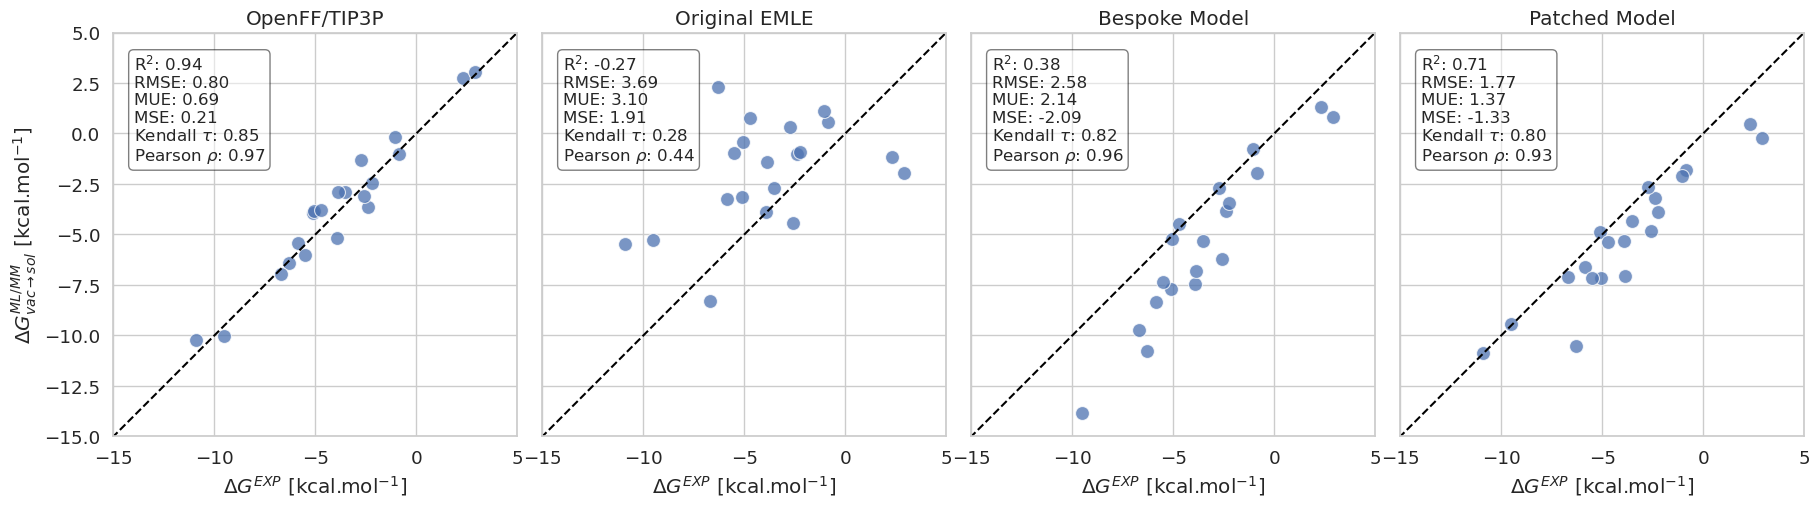

In [6]:
sns.set(style='whitegrid', font_scale=1.2)

columns_to_plot = df.columns[1:] # Exclude 'EXP'
num_plots = len(columns_to_plot)
ncols = 4
nrows = (num_plots + ncols - 1) // ncols 

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5 * nrows), sharex=True, sharey=True)

axes = axes.flatten()
xx = np.linspace(-100, 100, 100)
yy = xx

for i, column in enumerate(columns_to_plot):
    x = df['EXP']
    y = df[column]


    print(x-y)
    
    # Calculate statistics
    mue, mse, kendall, pearson, r2, rmse = compute_metrics(x, y)
  
    sns.lineplot(ax=axes[i], x=xx, y=yy, color='black', linestyle='--')
    sns.scatterplot(ax=axes[i], x=x, y=y, s=100, alpha=0.75)
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel(r'$\Delta G^{ML/MM}_{vac \rightarrow sol}$ [kcal.mol$^{-1}$]')
    axes[i].set_xlabel(r'$\Delta G^{EXP}$ [kcal.mol$^{-1}$]')
    
    stats_text = f"RMSE: {rmse:.2f}\nMSE: {mse:.2f}\nKendall's Tau: {kendall:.2f}\nR$^2$: {r2:.2f}\nPearson: {pearson:.2f}"

    axes[i].text(
        0.05,
        0.95,
        f"R$^2$: {r2:.2f}\nRMSE: {rmse:.2f} \nMUE: {mue:.2f}\nMSE: {mse:.2f}\nKendall $\\tau$: {kendall:.2f}\nPearson $\\rho$: {pearson:.2f}",
        transform=axes[i].transAxes,
        fontsize=12,
        verticalalignment="top",
        horizontalalignment="left",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3",alpha=0.5),
    )
    axes[i].grid(True)
    axes[i].set_xlim(-15, 5)
    axes[i].set_ylim(-15, 5)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

for ax in axes:
    ax.set_aspect('equal', 'box')


# reduce vertical space between subplots
plt.tight_layout(pad=0)  
# plt.savefig('fig4_ahfe_benchmark.pdf', bbox_inches='tight', dpi=300)
plt.show()